# Supervised Learning

In [29]:
import sys

assert sys.version_info >= (3, 7)
import pandas as pd

from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

In [30]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "decision_trees"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Import dataset and explore it

In [31]:
import openml
import pandas as pd

# Get Dataset from OPENML
dataset = openml.datasets.get_dataset(23)


df, *_ = dataset.get_data()

# Get features as X
X = df.drop('Contraceptive_method_used',axis=1)


# Get class as y
y = df['Contraceptive_method_used']

In [32]:
X

,Wifes_age,Wifes_education,Husbands_education,Number_of_children_ever_born,Wifes_religion,Wifes_now_working%3F,Husbands_occupation,Standard-of-living_index,Media_exposure
0,24,2,3,3,1,1,2,3,0
1,45,1,3,10,1,1,3,4,0
2,43,2,3,7,1,1,3,4,0
3,42,3,2,9,1,1,3,3,0
4,36,3,3,8,1,1,3,2,0
...,...,...,...,...,...,...,...,...,...
1468,33,4,4,2,1,0,2,4,0
1469,33,4,4,3,1,1,1,4,0
1470,39,3,3,8,1,0,1,4,0
1471,33,3,3,4,1,0,2,2,0


In [33]:
y.value_counts()

Contraceptive_method_used
1    629
3    511
2    333
Name: count, dtype: int64

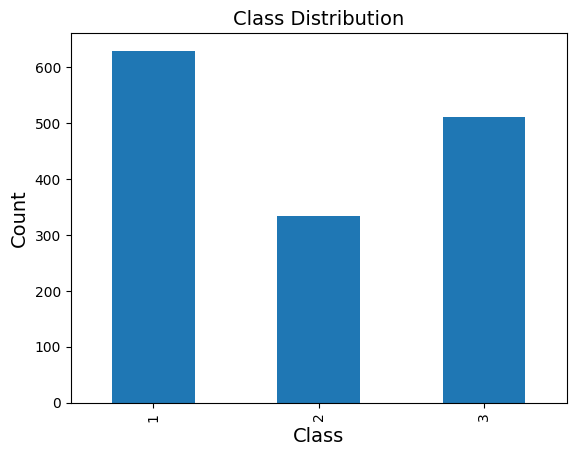

In [34]:
import matplotlib.pyplot as plt

y.value_counts().sort_index().plot(kind='bar')

# Add labels and title
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution')

plt.show()

In [35]:
X.head()

,Wifes_age,Wifes_education,Husbands_education,Number_of_children_ever_born,Wifes_religion,Wifes_now_working%3F,Husbands_occupation,Standard-of-living_index,Media_exposure
0,24,2,3,3,1,1,2,3,0
1,45,1,3,10,1,1,3,4,0
2,43,2,3,7,1,1,3,4,0
3,42,3,2,9,1,1,3,3,0
4,36,3,3,8,1,1,3,2,0


In [36]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1473 entries, 0 to 1472
Data columns (total 9 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   Wifes_age                     1473 non-null   uint8   
 1   Wifes_education               1473 non-null   category
 2   Husbands_education            1473 non-null   category
 3   Number_of_children_ever_born  1473 non-null   uint8   
 4   Wifes_religion                1473 non-null   category
 5   Wifes_now_working%3F          1473 non-null   category
 6   Husbands_occupation           1473 non-null   category
 7   Standard-of-living_index      1473 non-null   category
 8   Media_exposure                1473 non-null   category
dtypes: category(7), uint8(2)
memory usage: 14.2 KB


# Description of Dataset

The dataset is focused in predicting contraceptive method choice (no use, long-term methods, or short-term methods) of a woman based on her demographic and socio-economic characteristics. The samples come from a subset of the 1987 National Indonesia Contraceptive Prevalence Survey and they contain married women who were either not pregnant or do not know if they were at the time of interview.

It has 1473 instances with 10 features including the class. Information of the features:

Wife's age (16-49): numerical
Wife's education (categorical) 1=low, 2, 3, 4=high
Husband's education (categorical) 1=low, 2, 3, 4=high
Number of children ever born (0-16): numerical
Wife's religion (binary) 0=Non-Islam, 1=Islam
Wife's now working? (binary) 0=Yes, 1=No
Husband's occupation (categorical) 1, 2, 3, 4
Standard-of-living index (categorical) 1=low, 2, 3, 4=high
Media exposure (binary) 0=Good, 1=Not good
Contraceptive method used (class attribute) 1=No-use 2=Long-term 3=Short-term
(OpenMl, n.d.)

In this case, the categorical features are set as nominal, but if we observe there are some that may seem as ordinal because they use a low to high scale. For that reason, one of the aims is to treat those features as ordinal and the other is to treat it as nominal. After doing this, the performance will be evaluated to assess which option is the best. There are also no Nan values in the dataset.

As we can see above the classes are a bit unbalanced, because class 1 is 42.7% of the dataset, while class 2 is 34.69% and class 3 is 22.60%. So even if they don't have the same number of samples, they are still close to each other.

# Convert nominal to ordinal

We will use get_dummies for this because it allows us to separate the variables in a way in which we don't give more weight to a value.

In [37]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [38]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

def check_dummies(X_train, X_test, y_train, y_test,categorical_features):
    X_train_c = X_train.copy()
    X_test_c = X_test.copy()

    X_train_enc = pd.get_dummies(X_train_c, columns=categorical_features, drop_first=True)
    X_test_enc = pd.get_dummies(X_test_c, columns=categorical_features, drop_first=True)


    X_test_enc = X_test_enc.reindex(columns=X_train_enc.columns, fill_value=0)
    
    default_tree = DecisionTreeClassifier(random_state=42)
    default_tree.fit(X_train_enc, y_train)
    
        
    y_pred_default = default_tree.predict(X_test_enc)
    print(f"Tree depth: {default_tree.get_depth()}")
    print(classification_report(y_test, y_pred_default))

# Default Decision 

**Dummies just for Husbands_occupation**

In [39]:
categorical_features = ['Husbands_occupation']
check_dummies(X_train, X_test, y_train, y_test,categorical_features)

Tree depth: 23
              precision    recall  f1-score   support

           1       0.64      0.62      0.63       130
           2       0.41      0.39      0.40        71
           3       0.40      0.43      0.41        94

    accuracy                           0.51       295
   macro avg       0.48      0.48      0.48       295
weighted avg       0.51      0.51      0.51       295



# Default Decision Tree

**Dummies for all categorical variables**

In [40]:
categorical_features2 = ["Wifes_education",'Husbands_occupation',"Husbands_education","Standard-of-living_index" ]

check_dummies(X_train, X_test, y_train, y_test, categorical_features2)

Tree depth: 20
              precision    recall  f1-score   support

           1       0.62      0.64      0.63       130
           2       0.41      0.39      0.40        71
           3       0.45      0.45      0.45        94

    accuracy                           0.52       295
   macro avg       0.49      0.49      0.49       295
weighted avg       0.52      0.52      0.52       295



Therefore, the results with multiple dummies for the features have better results. We will treat the categorical variables as nominal, just as the web page in OpenML says. It is now possible to create a fine-tuned decision tree by converting the categorical features using dummies. Since the maximum depth of the default tree was 20, we'll set the height to 30 to have a margin of error.

Now, we need to decide the performance measure that we'll use. In this case, accuracy is not the best option because the decision will give more weight to class 1, given the initial class distribution that we saw first, which was moderately unbalanced. If we choose precision, we would overlook some of the classes. Thus, the model loses information about the woman's choice based on her characteristics. On the other hand, if we only use recall, the model may misclassify some classes, which would generate false conclusions and ultimately affect the interpretation of how women choose their contraceptive method. Therefore, in this case, the performance measure will be the F1-score because it is the harmonic mean of precision and recall, which means that we will consider both measures.

Since the dataset is slightly unbalanced we'll use stratified folds, so that the folds contain a representative ratio of each class.

In [41]:
X_train_c2 = X_train.copy()
X_test_c2 = X_test.copy()

#Use dummies
categorical_features = ["Wifes_education",'Husbands_occupation',"Husbands_education","Standard-of-living_index" ]
X_train_enc2 = pd.get_dummies(X_train_c2, columns=categorical_features, drop_first=True)
X_test_enc2 = pd.get_dummies(X_test_c2, columns=categorical_features, drop_first=True)

X_test_enc2 = X_test_enc2.reindex(columns=X_train_enc2.columns, fill_value=0)

In [42]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold

cv = RepeatedStratifiedKFold(n_splits=20, n_repeats=10, random_state=42)


param_grid = {
    'max_depth': [None, 5, 10, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}


# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=42),
    param_grid=param_grid,
    scoring='f1_weighted',  
    cv=cv,
)

grid_search.fit(X_train_enc2, y_train)

best_tree = grid_search.best_estimator_


y_pred_default = best_tree.predict(X_test_enc2)
print(classification_report(y_test, y_pred_default))


print("Best parameters:", grid_search.best_params_)
print("Best weighted F1 score:", grid_search.best_score_)

              precision    recall  f1-score   support

           1       0.73      0.54      0.62       130
           2       0.56      0.42      0.48        71
           3       0.44      0.68      0.54        94

    accuracy                           0.56       295
   macro avg       0.58      0.55      0.55       295
weighted avg       0.60      0.56      0.56       295

Best parameters: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 10}
Best weighted F1 score: 0.5528766823464109


We chose 20 splits and 10 repeats for RepeatedStratifiedKFold because this combination gave the best result for the f1-score after trying different values.

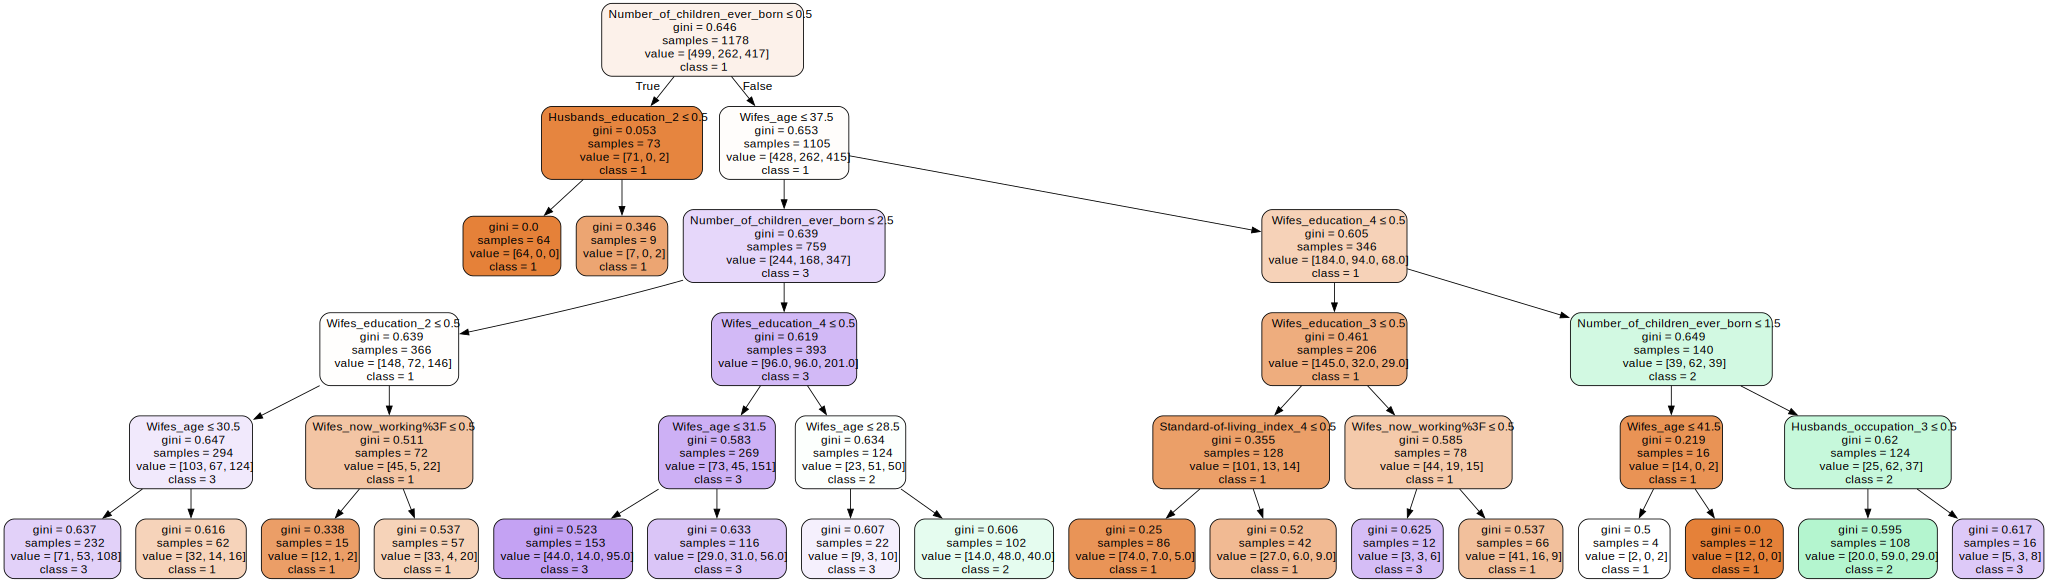

In [45]:
from sklearn.tree import export_graphviz
from graphviz import Source

export_graphviz(
    best_tree,
    out_file=str(IMAGES_PATH / "best_tree.dot"),
    feature_names=X_train_enc2.columns,
    class_names=["1", "2", "3"],
    rounded=True,
    filled=True,
    special_characters=True,
)


Source.from_file(IMAGES_PATH / "best_tree.dot")